In [18]:
#First out imports
#Lets import some stuff!

#Numpy
import numpy as np

#Cartopy for mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from metpy.units import units
import metpy.calc as mpcalc


#Matplotlib for plotting
import matplotlib.pyplot as plt

#Siphon for finding data
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

#date tools
from datetime import datetime, timedelta
from netCDF4 import num2date

#os tools
import os

%matplotlib inline

In [21]:
wx_code_map = {'': 0, 'DU': 7, 'BLDU': 7, 'HZ': 5, 'BR': 10, '-UP': 16, 'UP': 16, 'SQ': 18, 'FC': 19,
               'DRSN': 36, 'FG': 45, 'FZFG': 49, '-DZ': 51, 'DZ': 53, '+DZ': 55,
               '-RA': 61, 'RA': 63, '+RA': 65, '-FZRA': 66,
               '-SN': 71, 'SN': 73, '+SN': 75, '-SHRA': 80, 'SHRA': 81, '-SHSN': 85, '+TSRA': 97,
               'TSRA': 95, '-TSRA': 95, 'VCTSRA': 95}


def to_code(text):
    for s in text:
        if ' ' in s:
            yield max(to_code(s.split()))
        else:
            yield wx_code_map[s]


In [24]:
#UNIDATA thredds location 
metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'

# parse the xml
metar_cat = TDSCatalog(metar_cat_url)

# what datasets are here? only one "dataset" in this catalog
dataset = list(metar_cat.datasets.values())[0]
ncss_url = dataset.access_urls["NetcdfSubset"]
ncss = NCSS(ncss_url)


In [28]:
#Bounding box for our query
# 42.3479262,-71.1334236,11.74z
bb={'west':-85., 'east':-65.0,'north':55, 'south':35.0}

#create a new query for the server

query = ncss.query().accept('csv').time(datetime.utcnow() - timedelta(minutes=1))
query.lonlat_box(**bb)
query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather', 'report_id')


data = ncss.get_data(query)
#Pass the bounding box through
#query.lonlat_box(**bb)

#what measurements do we want?
#query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
#                'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather',
#               'report_id', 'precipitation_amount_hourly', 'precipitation_amount_24')

#restrict to last 1200 hours.. that should be enough data
#query.time_range(datetime(2018, 8, 3) , datetime(2018, 9, 1) )
#query.accept('csv')

#run the query!
#data = ncss.get_data(query)


/Users/scollis/anaconda3/envs/pchange/lib/python3.6/site-packages/siphon/ncss.py:433: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  converters={'date': lambda s: parse_iso_date(s.decode('utf-8'))})


In [29]:
#Two seperate dictionaries for the data and its locations
station_dict={}
locs ={}

#What variables do we want to extract as data points
want = ('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather')

#determine the names of the unique stations
stations = np.unique(data['report_id'])

#Loop over each station
for station in stations:
    #identify where in the returned array the station we
    #are interested is.
    wstat = np.where(data['report_id'] == station)
    
    #Grab lat, lon and print and update locs dic
    lat = np.unique(data['latitude'][wstat])
    lon = np.unique(data['longitude'][wstat])
    print(station, lat, lon)
    locs.update({station.decode('UTF-8'): (lat, lon)})
    
    #create a list of python datetime objects from date string
    dates_list = [datetime.strptime(date.decode('UTF-8'), "%Y-%m-%dT%H:%M:%SZ") for date in data['time'][wstat]]
    
    #Create a list of indexes that we can use to sort each station's data by time
    arrrrg = np.array(dates_list).argsort()
    this = {}
    
    #for each variable update the station dictionary with the data
    for key in want:
        this.update({key:data[key][wstat][arrrrg]})
    
    #Add time, time strings and add this station to the master station
    #dictionary
    this.update({'time': np.array(dates_list)[arrrrg]} )
    this.update({'timestr': data['time'][wstat][arrrrg]})
    station_dict.update({station.decode('UTF-8'):this})

b'CMGB' [45.369] [-72.769]
b'CYGL' [53.63] [-77.699]
b'CYKF' [43.47] [-80.379]
b'CYMT' [49.77] [-74.529]
b'CYTZ' [43.63] [-79.4]
b'CZMT' [49.77] [-74.55]
b'K12N' [41.009] [-74.739]
b'K1A5' [35.22] [-83.419]
b'K1A6' [36.61] [-83.739]
b'K1P1' [43.779] [-71.75]
b'K1V4' [44.419] [-72.019]
b'K2G4' [39.58] [-79.339]
b'K40B' [46.619] [-69.529]
b'KABE' [40.65] [-75.43]
b'KACY' [39.45] [-74.569]
b'KADW' [38.819] [-76.87]
b'KAFJ' [40.13] [-80.279]
b'KAGC' [40.349] [-79.93]
b'KALB' [42.75] [-73.8]
b'KAMN' [43.319] [-84.69]
b'KANJ' [46.479] [-84.37]
b'KAOH' [40.709] [-84.029]
b'KART' [44.] [-76.019]
b'KASH' [42.779] [-71.519]
b'KASJ' [36.299] [-77.169]
b'KAVC' [36.689] [-78.05]
b'KAVP' [41.33] [-75.73]
b'KBAX' [43.79] [-82.989]
b'KBCB' [37.22] [-80.419]
b'KBED' [42.47] [-71.279]
b'KBHB' [44.45] [-68.37]
b'KBID' [41.169] [-71.58]
b'KBJJ' [40.869] [-81.889]
b'KBLM' [40.18] [-74.129]
b'KBTP' [40.779] [-79.949]
b'KCEF' [42.2] [-72.529]
b'KCFS' [43.459] [-83.449]
b'KCGE' [38.54] [-76.029]
b'KCIU' [46.2

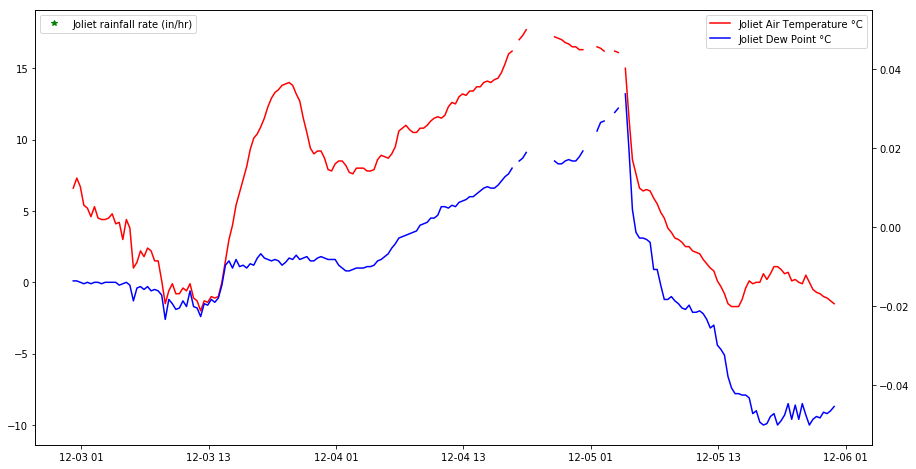

In [62]:

#make a nice visual!
fig = plt.figure(figsize = [15,8])
plt.plot(station_dict['KLOT']['time'], 
         station_dict['KLOT']['air_temperature'], 
         'r-', label=u'Joliet Air Temperature \u00b0C')
plt.plot(station_dict['KLOT']['time'], 
         station_dict['KLOT']['dew_point_temperature'], 
         'b-', label=u'Joliet Dew Point \u00b0C')
plt.legend()
ax2= plt.twinx()
plt.plot(station_dict['KLOT']['time'], 
         station_dict['KLOT']['precipitation_amount_hourly'], 'g*',
        label='Joliet rainfall rate (in/hr)')
plt.legend(loc=2)
plt.savefig('../images/KLOT.png')

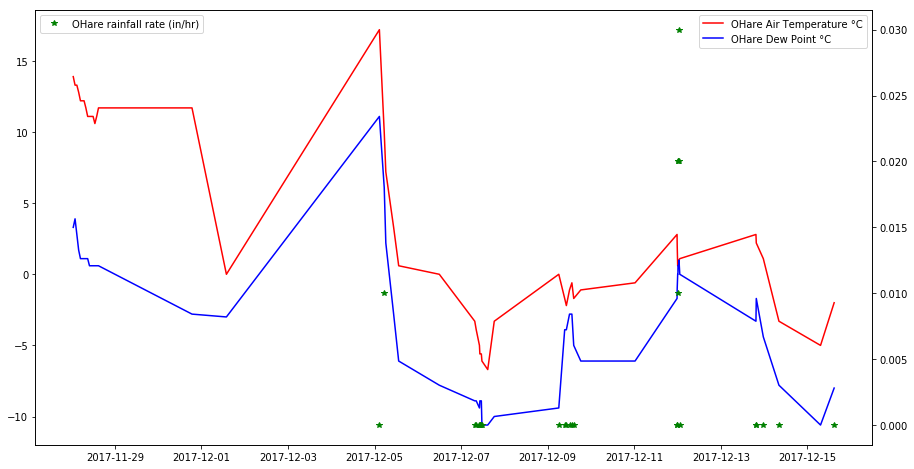

In [38]:

#make a nice visual!
fig = plt.figure(figsize = [15,8])
plt.plot(station_dict['KMDW']['time'], 
         station_dict['KMDW']['air_temperature'], 
         'r-', label=u'OHare Air Temperature \u00b0C')
plt.plot(station_dict['KMDW']['time'], 
         station_dict['KMDW']['dew_point_temperature'], 
         'b-', label=u'OHare Dew Point \u00b0C')
plt.legend()
ax2= plt.twinx()
plt.plot(station_dict['KMDW']['time'], 
         station_dict['KMDW']['precipitation_amount_hourly'], 'g*',
        label='OHare rainfall rate (in/hr)')
plt.legend(loc=2)
plt.savefig('../images/KORD.png')

In [39]:
#Where to save the data.. and create a header for each CSV file
out_dir = '/Users/scollis/projects/precip_change/data/'
headers = ''
for key in list(station_dict[list(station_dict.keys())[0]].keys()):
    headers += key +","
headers = headers[:-1]+'\n'

#For each station create a CSV file of the data
for key in station_dict.keys():
    print(key)
    fh = open(os.path.join(out_dir, key+'.csv'), 'w')
    fh.write(headers)
    varss = list(station_dict[key].keys())
    for i in range(len(station_dict[key][varss[0]])):
        this_line =''
        for vkey in varss:
            this_line += str(station_dict[key][vkey][i])+','
        this_line = this_line[:-1]+'\n'
        fh.write(this_line)
    fh.close()



KAAA
KAID
KALO
KARR
KASW
KAWG
KAZO
KBEH
KBIV
KBMI
KBRL
KBTL
KBUU
KC09
KC75
KCID
KCMI
KCMY
KCWI
KDBQ
KDEH
KDKB
KDLL
KDNV
KDPA
KDVN
KEFT
KEKM
KENW
KEOK
KETB
KFEP
KFFL
KFKA
KFLD
KFSW
KFWA
KGBG
KGRR
KGSH
KGUS
KGYY
KHAI
KIGQ
KIIB
KIKK
KIOW
KIRS
KJOT
KJVL
KLAF
KLDM
KLNR
KLOT
KLSE
KLWA
KMDW
KMIE
KMKE
KMKG
KMLI
KMPZ
KMQB
KMRJ
KMSN
KMUT
KMWC
KMXO
KOEB
KOKK
KOLZ
KOOA
KORD
KOSH
KOTM
KOVS
KPDC
KPIA
KPNT
KPWK
KRAC
KRFD
KRPJ
KRQB
KRST
KRYV
KSBM
KSBN
KSFY
KSQI
KTIP
KUES
KUGN
KUNU
KVOK
KVPZ
KVTI
KVYS


In [67]:
high_res = {}
for st in station_dict.keys():
    npts = len(station_dict[st]['time'])
    print(st, npts)
    if npts > 50:
        high_res.update({st : station_dict[st]})
        high_res[st].update({'station': [st] * npts})
        high_res[st]['lat'] = list(locs[st][0]) * npts
        high_res[st]['lon'] = list(locs[st][1]) * npts


CPBT 73
CPEH 73
CPFI 73
CPIR 73
CPRO 73
CPRY 72
CPST 70
CPSV 73
CPXL 73
CWAV 73
CWBO 73
CWBU 73
CWCF 73
CWCI 73
CWCJ 73
CWCT 32
CWDJ 33
CWDK 73
CWDV 73
CWDZ 73
CWEH 73
CWEQ 73
CWFF 73
CWFJ 73
CWGM 73
CWGW 73
CWGY 73
CWHI 71
CWHN 176
CWII 73
CWIK 73
CWIW 73
CWJD 73
CWJI 73
CWJX 73
CWKO 31
CWLB 73
CWLE 73
CWMQ 73
CWNK 73
CWOE 71
CWOY 73
CWPO 73
CWRJ 73
CWRM 73
CWRT 73
CWRY 73
CWSR 73
CWSW 35
CWVI 73
CWVN 73
CWVP 73
CWWF 73
CWWS 72
CWXL 73
CWZS 73
CXAF 73
CXAG 73
CXAJ 73
CXAK 73
CXBA 73
CXBK 73
CXBR 73
CXBW 73
CXCA 73
CXCP 73
CXCS 73
CXDB 73
CXDP 73
CXDW 73
CXEA 73
CXEC 73
CXEG 73
CXFM 73
CXGH 73
CXHD 54
CXHR 73
CXKM 73
CXMD 73
CXMO 73
CXOL 73
CXOY 73
CXPL 73
CXRL 71
CXSC 73
CXSL 73
CXSP 73
CXTH 71
CXVM 73
CXWM 70
CXWN 73
CYBR 86
CYBU 138
CYBV 24
CYBW 111
CYDN 130
CYED 80
CYEG 104
CYEN 97
CYFO 42
CYGQ 129
CYHD 319
CYIV 85
CYKY 85
CYLJ 53
CYLL 138
CYMJ 38
CYNE 133
CYOD 86
CYPA 106
CYPG 31
CYPL 60
CYQD 79
CYQF 96
CYQK 101
CYQL 79
CYQR 121
CYQT 127
CYQV 136
CYQW 210
CYRL 81
CYTL 164
CYWG 90


In [68]:
#Where to save the data.. and create a header for each CSV file
out_dir = '/Users/scollis/funded_projects/precip_change/data/highres2/'
headers = ''
for key in list(high_res[list(high_res.keys())[0]].keys()):
    headers += key +","
headers = headers[:-1]+'\n'

#For each station create a CSV file of the data
for key in high_res.keys():
    print(key)
    fh = open(os.path.join(out_dir, key+'.csv'), 'w')
    fh.write(headers)
    varss = list(high_res[key].keys())
    for i in range(len(high_res[key][varss[0]])):
        this_line =''
        for vkey in varss:
            this_line += str(high_res[key][vkey][i])+','
        this_line = this_line[:-1]+'\n'
        fh.write(this_line)
    fh.close()

CPBT
CPEH
CPFI
CPIR
CPRO
CPRY
CPST
CPSV
CPXL
CWAV
CWBO
CWBU
CWCF
CWCI
CWCJ
CWDK
CWDV
CWDZ
CWEH
CWEQ
CWFF
CWFJ
CWGM
CWGW
CWGY
CWHI
CWHN
CWII
CWIK
CWIW
CWJD
CWJI
CWJX
CWLB
CWLE
CWMQ
CWNK
CWOE
CWOY
CWPO
CWRJ
CWRM
CWRT
CWRY
CWSR
CWVI
CWVN
CWVP
CWWF
CWWS
CWXL
CWZS
CXAF
CXAG
CXAJ
CXAK
CXBA
CXBK
CXBR
CXBW
CXCA
CXCP
CXCS
CXDB
CXDP
CXDW
CXEA
CXEC
CXEG
CXFM
CXGH
CXHD
CXHR
CXKM
CXMD
CXMO
CXOL
CXOY
CXPL
CXRL
CXSC
CXSL
CXSP
CXTH
CXVM
CXWM
CXWN
CYBR
CYBU
CYBW
CYDN
CYED
CYEG
CYEN
CYGQ
CYHD
CYIV
CYKY
CYLJ
CYLL
CYNE
CYOD
CYPA
CYPL
CYQD
CYQF
CYQK
CYQL
CYQR
CYQT
CYQV
CYQW
CYRL
CYTL
CYWG
CYXE
CYXH
CYXL
CYYC
CYYN
CZMJ
CZMU
CZOL
CZPC
CZPS
CZTB
K04V
K0CO
K1H2
K20V
K2WX
K3LF
K4BM
K5SM
K7BM
K8D3
K9V9
KAAA
KACB
KACQ
KADC
KADU
KAEL
KAFF
KAFK
KAIG
KAIO
KAIT
KAJG
KALN
KANE
KANW
KAQP
KARV
KASW
KATW
KATY
KAUH
KAUM
KAVK
KAWG
KAXA
KBBB
KBDE
KBDH
KBFW
KBIE
KBJC
KBJI
KBKF
KBNW
KBUU
KBVN
KBWP
KBZN
KC09
KC75
KCAD
KCAG
KCAV
KCBF
KCBG
KCCU
KCCY
KCDD
KCDJ
KCFE
KCHK
KCIN
KCIR
KCKC
KCKN
KCKP
KCLI
KCLK
KCMX
KCMY
KCNB
KCNC
KCOQ


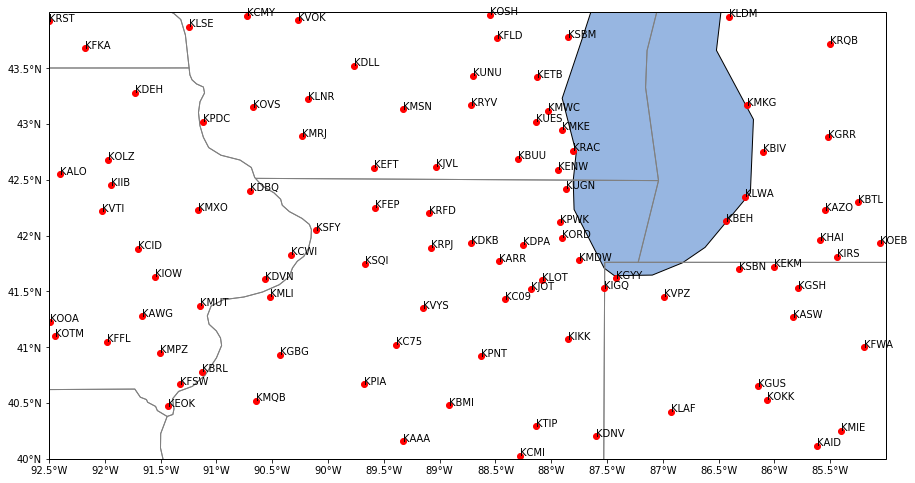

In [42]:

#Just to make sure, lets plot the location of all our METARS
tk = .5
north = bb['north']
south = bb['south']
west = bb['west']
east = bb['east']
bbox = [west, east, south,north]

fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks(np.arange(west, east, tk), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(south, north, tk), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_extent(bbox)
ax.add_feature(cfeature.LAKES, edgecolor='k')
ax.add_feature(cfeature.RIVERS)
states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
_ = ax.add_feature(states, edgecolor='gray')
for station_name in list(locs.keys()):
    ax.plot(locs[station_name][1], locs[station_name][0], 'ro')
    ax.text(locs[station_name][1], locs[station_name][0], station_name)
plt.savefig('../images/locations_midwest.png')

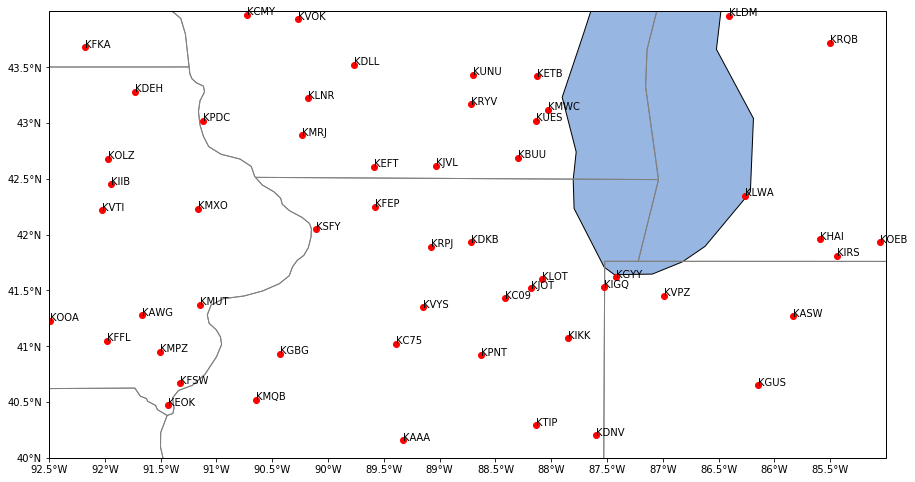

In [51]:

#Just to make sure, lets plot the location of all our METARS
tk = .5
north = bb['north']
south = bb['south']
west = bb['west']
east = bb['east']
bbox = [west, east, south,north]

fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks(np.arange(west, east, tk), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(south, north, tk), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_extent(bbox)
ax.add_feature(cfeature.LAKES, edgecolor='k')
ax.add_feature(cfeature.RIVERS)
states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
_ = ax.add_feature(states, edgecolor='gray')
for station_name in list(high_res.keys()):
    ax.plot(high_res[station_name]['loc'][1], high_res[station_name]['loc'][0], 'ro')
    ax.text(high_res[station_name]['loc'][1], high_res[station_name]['loc'][0], station_name)
plt.savefig('../images/locations_midwest_highres.png')

In [19]:
def get_obs(ts, mybb):
    # copied from the browser url box
    metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
    # parse the xml
    metar_cat = TDSCatalog(metar_cat_url)
    # what datasets are here? only one "dataset" in this catalog
    dataset = list(metar_cat.datasets.values())[0]
    ncss_url = dataset.access_urls["NetcdfSubset"]
    ncss = NCSS(ncss_url)

    query = ncss.query().accept('csv').time(ts - timedelta(minutes=1))
    query.lonlat_box(**mybb)
    query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                    'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather')


    data = ncss.get_data(query)
    lats = data['latitude'][:]
    lons = data['longitude'][:]
    tair = data['air_temperature'][:]
    dewp = data['dew_point_temperature'][:]
    slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

    # Convert wind to components
    u, v = mpcalc.get_wind_components(data['wind_speed'] * units.knot,
                                      data['wind_from_direction'] * units.deg)

    # Need to handle missing (NaN) and convert to proper code
    cloud_cover = 8 * data['cloud_area_fraction']
    cloud_cover[np.isnan(cloud_cover)] = 9
    cloud_cover = cloud_cover.astype(np.int)

    # For some reason these come back as bytes instead of strings
    stid = [s.decode() for s in data['station']]

    # Convert the text weather observations to WMO codes we can map to symbols
    if data['weather'].dtype != bool:
        wx_text = [s.decode('ascii') for s in data['weather']]
        wx_codes = np.array(list(to_code(wx_text)))
    else:
        wx_codes = np.array([0] * len(data['weather']))

    sfc_data = {'latitude': lats, 'longitude': lons,
                'air_temperature': tair, 'dew_point_temperature': dewp, 'eastward_wind': u,
                'northward_wind': v, 'cloud_coverage': cloud_cover,
                'air_pressure_at_sea_level': slp, 'present_weather': wx_codes}
    
    return sfc_data

In [22]:
dd = get_obs(datetime.utcnow(), bb)

/Users/scollis/anaconda3/envs/pchange/lib/python3.6/site-packages/siphon/ncss.py:433: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  converters={'date': lambda s: parse_iso_date(s.decode('utf-8'))})
/Users/scollis/anaconda3/envs/pchange/lib/python3.6/site-packages/metpy/xarray.py:381: MetpyDeprecationWarning: The get_wind_components function was deprecated in version 0.9. This function has been renamed wind_components.
  return func(*args, **kwargs)
/Users/scollis/anaconda3/envs/pchange/lib/python3.6/site-packages/metpy/calc/basic.py:736: UserWarning: Input over 12.566370614359172 radians. Ensure proper units are given.
  'Ensure proper units are given.'.format(max_radians))


In [23]:
dd

{'latitude': array([41.009, 35.22 , 36.61 , 43.779, 44.419, 39.58 , 46.619, 40.65 ,
        39.45 , 39.45 , 39.45 , 38.819, 40.13 , 40.349, 42.75 , 43.319,
        46.479, 40.709, 44.   , 42.779, 36.299, 36.689, 41.33 , 43.79 ,
        37.22 , 42.47 , 41.169, 40.869, 40.18 , 40.779, 43.459, 38.54 ,
        38.529, 36.659, 38.369, 40.22 , 38.72 , 39.9  , 42.88 , 41.34 ,
        39.279, 46.009, 42.569, 41.74 , 41.369, 40.33 , 36.029, 42.9  ,
        35.25 , 38.88 , 42.11 , 36.689, 38.799, 35.779, 38.27 , 37.13 ,
        35.13 , 36.02 , 39.83 , 41.049, 41.38 , 36.7  , 41.65 , 41.65 ,
        42.569, 35.43 , 40.729, 37.349, 41.2  , 37.52 , 42.099, 45.47 ,
        41.33 , 35.33 , 44.049, 35.459, 39.36 , 35.029, 40.18 , 36.77 ,
        40.09 , 36.36 , 41.069, 35.38 , 37.95 , 40.959, 38.369, 40.819,
        41.669, 43.43 , 37.599, 40.63 , 39.68 , 35.479, 35.33 , 40.799,
        42.479, 37.229, 42.15 , 35.54 , 40.319, 42.27 , 41.919, 39.08 ,
        43.569, 39.819, 44.049, 36.02 , 38.009, 41.6